In [1]:
#EDA of dataset
# Load data
import numpy as np
import pandas as pd
data1 = pd.read_csv('data1.csv')




In [2]:
print(data1.isnull().sum().sum())  # Total number of NaNs
print(data1['Class'].sum())

0
492


In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier


#seed_value changed
# Step 1: Split dataset into 70%, 15%, 15% without stratification
train_data, temp_data = train_test_split(data1, test_size=0.3, random_state=43)
test1_data, test2_data = train_test_split(temp_data, test_size=0.5, random_state=43)
print(train_data.isnull().sum().sum(),test1_data.isnull().sum().sum(),test2_data.isnull().sum().sum())
print(train_data['Class'].sum(),test1_data['Class'].sum(),test2_data['Class'].sum())



0 0 0
342 70 80


In [4]:
# Step 2: Prepare SVM training data (legitimate transactions only from train_data)
X_train_nonfraud = train_data[train_data['Class'] == 0].drop(['Time', 'Class'], axis=1)

# Train OneClassSVM
svm = OneClassSVM(gamma='auto', nu=0.01, verbose=1)
svm.fit(X_train_nonfraud)

# Step 3: Detect grey area transactions in test1_data
X_test1 = test1_data.drop(['Time', 'Class'], axis=1)
svm_pred_test1 = svm.predict(X_test1)  # -1 = anomaly, 1 = normal

# Add predictions to test1_data and filter grey area
test1_data = test1_data.copy()  # Avoid SettingWithCopyWarning
test1_data['SVM_Flag'] = svm_pred_test1
grey_area = test1_data[test1_data['SVM_Flag'] == -1]
print(len(grey_area))





[LibSVM]2233


In [5]:
# Step 4: Prepare RF training data (use original labels)
X_grey = grey_area.drop(['Time', 'Class', 'SVM_Flag'], axis=1)
y_grey = grey_area['Class']

# Step 5: Train Random Forest (remove n_bins parameter)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    verbose=1
)
rf.fit(X_grey, y_grey)

# Step 6: Predict on test2_data and evaluate
X_test2 = test2_data.drop(['Time', 'Class'], axis=1)
y_test2 = test2_data['Class']
rf_pred_test2 = rf.predict_proba(X_test2)[:, 1]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [6]:
rf_pred_test2 = (rf_pred_test2 > 0.5).astype(int)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix


# 1. OneClassSVM on Train Set
# svm_pred_train: +1 (normal), -1 (anomaly). Map to 0 (legit), 1 (fraud) for report.
X_train = train_data.drop(['Time', 'Class'], axis=1)
y_train = train_data['Class']
X_train.isnull().sum().sum(), y_train.isnull().sum().sum()


(0, 0)

In [8]:
labels = [0, 1]
target_names = ['Legitimate', 'Fraud']

svm_pred_train = svm.predict(X_train)
svm_pred_train_labels = np.where(svm_pred_train == 1, 0, 1)


# 1. OneClassSVM on Train Set
print("\n[OneClassSVM] Classification Report on Train Set:")
print(classification_report(y_train, svm_pred_train_labels, target_names=target_names))
print("[OneClassSVM] Confusion Matrix on Train Set:")
print(confusion_matrix(y_train, svm_pred_train_labels, labels=labels))


# 2. OneClassSVM on Test1 Set
y_test1 = test1_data['Class']
svm_pred_test1_labels = np.where(test1_data['SVM_Flag'] == 1, 0, 1)
print("\n[OneClassSVM] Classification Report on Test1 Set:")
print(classification_report(y_test1, svm_pred_test1_labels, target_names=target_names))
print("[OneClassSVM] Confusion Matrix on Test1 Set:")
print(confusion_matrix(y_test1, svm_pred_test1_labels, labels=labels))


# 3. Random Forest on Grey Area Transactions (from Test1)
# y_grey and X_grey already defined
y_grey_pred = rf.predict(X_grey)
print("\n[RandomForest] Classification Report on SVM-Flagged (Grey Area) Transactions (Test1):")
print(classification_report(y_grey, y_grey_pred, target_names=target_names))
print("[RandomForest] Confusion Matrix on SVM-Flagged (Grey Area) Transactions (Test1):")
print(confusion_matrix(y_grey, y_grey_pred, labels=labels))




[OneClassSVM] Classification Report on Train Set:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99    199022
       Fraud       0.06      0.86      0.11       342

    accuracy                           0.97    199364
   macro avg       0.53      0.92      0.55    199364
weighted avg       1.00      0.97      0.99    199364

[OneClassSVM] Confusion Matrix on Train Set:
[[194068   4954]
 [    47    295]]

[OneClassSVM] Classification Report on Test1 Set:
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97     42651
       Fraud       0.03      0.84      0.05        70

    accuracy                           0.95     42721
   macro avg       0.51      0.90      0.51     42721
weighted avg       1.00      0.95      0.97     42721

[OneClassSVM] Confusion Matrix on Test1 Set:
[[40477  2174]
 [   11    59]]

[RandomForest] Classification Report on SVM-Flagged (Grey Area) Transactions (Test1):
 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [9]:

# 4. Random Forest on Test2 Set
# y_test2 and rf_pred_test2 already defined
print("\n[RandomForest] Classification Report on Test2 Set:")
print(classification_report(y_test2, rf_pred_test2, target_names=target_names))
print("[RandomForest] Confusion Matrix on Test2 Set:")
print(confusion_matrix(y_test2, rf_pred_test2, labels=labels))


[RandomForest] Classification Report on Test2 Set:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     42642
       Fraud       0.84      0.71      0.77        80

    accuracy                           1.00     42722
   macro avg       0.92      0.86      0.88     42722
weighted avg       1.00      1.00      1.00     42722

[RandomForest] Confusion Matrix on Test2 Set:
[[42631    11]
 [   23    57]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


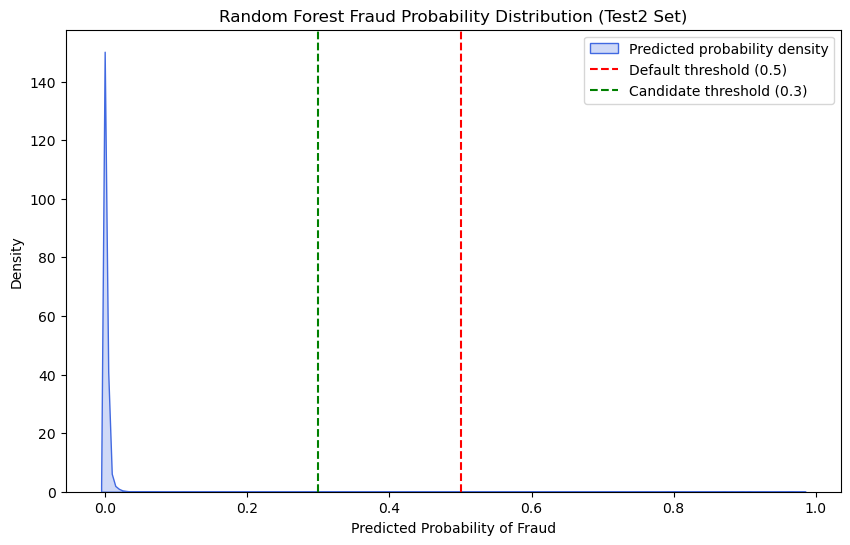

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for the fraud class (class 1)
y_proba = rf.predict_proba(X_test2)[:, 1]

plt.figure(figsize=(10, 6))
sns.kdeplot(y_proba, bw_adjust=0.5, fill=True, color='royalblue', label='Predicted probability density')

# Mark the default threshold
plt.axvline(0.5, color='red', linestyle='--', label='Default threshold (0.5)')
# Optionally, mark your candidate threshold
plt.axvline(0.3, color='green', linestyle='--', label='Candidate threshold (0.3)')

plt.title('Random Forest Fraud Probability Distribution (Test2 Set)')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Density')
plt.legend()
plt.show()



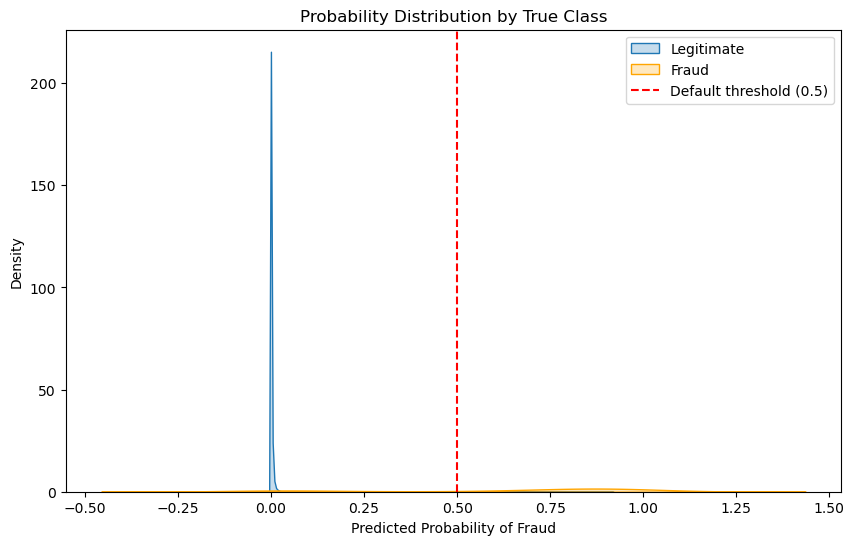

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_proba[y_test2 == 0], label='Legitimate', fill=True)
sns.kdeplot(y_proba[y_test2 == 1], label='Fraud', fill=True, color='orange')
plt.axvline(0.5, color='red', linestyle='--', label='Default threshold (0.5)')
plt.title('Probability Distribution by True Class')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Density')
plt.legend()
plt.show()


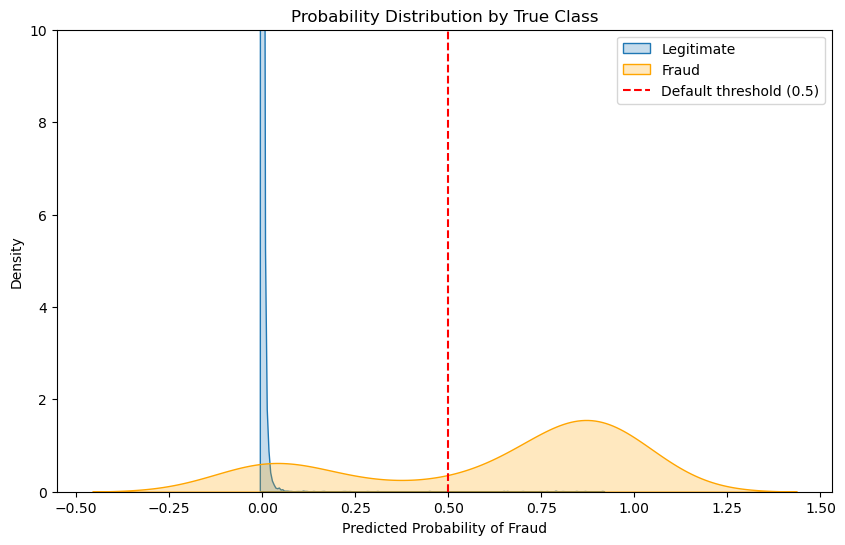

In [12]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_proba[y_test2 == 0], label='Legitimate', fill=True)
sns.kdeplot(y_proba[y_test2 == 1], label='Fraud', fill=True, color='orange')
plt.axvline(0.5, color='red', linestyle='--', label='Default threshold (0.5)')
plt.title('Probability Distribution by True Class')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Density')
plt.ylim(0, 10)  # Set y-axis scale from 0 to 10
plt.legend()
plt.show()



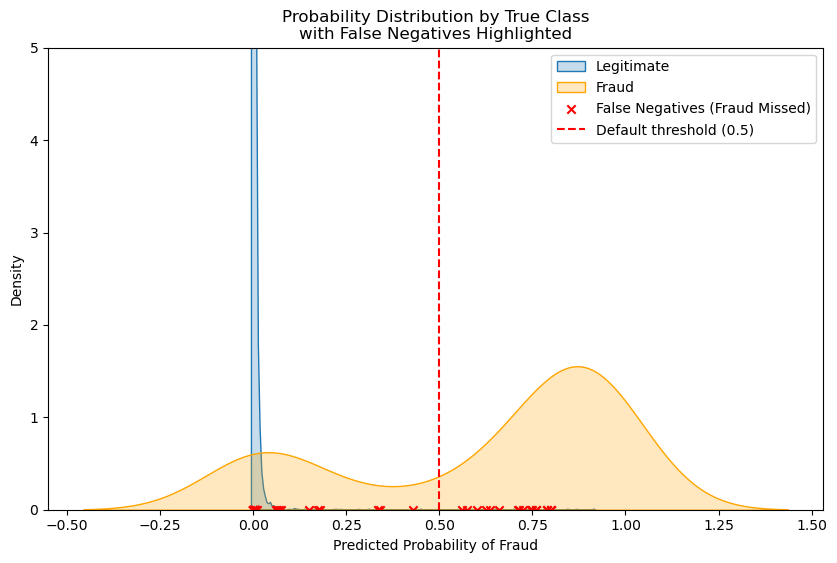

In [13]:
# Your predictions at default threshold (0.5)
rf_pred_test2 = (y_proba > 0.8).astype(int)
# Find indices of false negatives
false_negatives = (y_test2 == 1) & (rf_pred_test2 == 0)
# Probabilities assigned to these false negatives
fn_probs = y_proba[false_negatives]
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# KDE for legitimate
sns.kdeplot(y_proba[y_test2 == 0], label='Legitimate', fill=True)
# KDE for fraud
sns.kdeplot(y_proba[y_test2 == 1], label='Fraud', fill=True, color='orange')
# Plot false negatives as rug or scatter
plt.scatter(fn_probs, [0]*len(fn_probs), color='red', marker='x', label='False Negatives (Fraud Missed)')

# Threshold lines
plt.axvline(0.5, color='red', linestyle='--', label='Default threshold (0.5)')

plt.title('Probability Distribution by True Class\nwith False Negatives Highlighted')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Density')
plt.ylim(0, 5)
plt.legend()
plt.show()
